### Lendo, tratando dados e visualizações básicas

In [111]:
import pandas as pd

path = r'C:\Users\ghumb\Desktop\Aneel_Energisa\Codigos\df.xlsx'
df = pd.read_excel(path)

In [719]:
# Atualizando formato de colunas
def atualiza_formato_colunas(df):
    df = df.astype({
        "NumCNPJDistribuidora": np.int64,
        "CodClasseConsumo": np.int64,
        "CodSubGrupoTarifario": np.int64,
        "codUFibge": np.float64,
        "codRegiao": np.float64,
        "CodMunicipioIbge": np.float64,
        "QtdUCRecebeCredito": np.int64,
    })
    return df

# análise de vazios
def analyze_dataframe(df):
    # Análise de colunas duplicadas
    duplicated_cols = df.columns[df.columns.duplicated(keep=False)]
    df_duplicated_col = df[duplicated_cols].sum()
    print('Colunas duplicadas: ', df_duplicated_col.tolist())

    # Análise de linhas duplicadas
    duplicated_rows = df.duplicated(keep=False)
    df_duplicated_line = duplicated_rows.sum()
    print('Linhas duplicadas: ', df_duplicated_line.tolist())

    # Análise de valores nulos
    na_tot = df.isna().sum().sort_values(ascending=False)
    na_perc = (df.isna().sum() / df.shape[0] * 100).round(2).sort_values(ascending=False)
    na = pd.concat([na_tot, na_perc], axis=1, keys=['+', '%'])
    print(na.head(10))

def check_duplicates(df):
    # Verifica colunas duplicadas
    duplicated_cols = df.columns[df.columns.duplicated(keep=False)]
    num_duplicated_cols = len(duplicated_cols)
    
    # Verifica linhas duplicadas
    duplicated_rows = df.duplicated(keep=False)
    num_duplicated_rows = duplicated_rows.sum()
    
    # Retorna o resultado
    return num_duplicated_cols, num_duplicated_rows



def visualizar_nulos(df):
    sorted_df = df.sort_values(by='NumCoordEEmpreendimento')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Cria a matriz de visualização de nulos com o eixo x em rotação vertical e tamanho de fonte menor
    matriz_nulos = msno.matrix(sorted_df, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    
    plt.show()


df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year
df['Ano_Mes'] = pd.to_datetime(df['DthAtualizaCadastralEmpreend']).dt.strftime('%Y-%m')

# exclui nulos
df_clean = df.dropna(subset=['NumCPFCNPJ']).copy()

ts = df_clean.groupby(['DthAtualizaCadastralEmpreend', 'SigUF','SigTipoConsumidor', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
ts = ts.sort_values('DthAtualizaCadastralEmpreend')
ts = ts.set_index('DthAtualizaCadastralEmpreend')


ts_clean = ts.drop(['SigUF', 'SigTipoConsumidor','DscClasseConsumo'], axis=1)
ts_clean = ts_clean.groupby('DthAtualizaCadastralEmpreend').sum()


ts_clean

,NumCPFCNPJ
DthAtualizaCadastralEmpreend,
2012-02-03,1
2013-10-24,1
2014-02-05,1
2014-03-17,1
2014-06-05,1
...,...
2023-03-18,21
2023-03-20,25
2023-03-21,19


#### Calculando Erros

# Modelos de previsão

#### Antes de escolher um modelo é importante:
        - Conhecer os dados (tendências, sazonalidades, resíduos, autocorrelações, distribuição e outliers)
        - Definir os objetivos da previsão (interpretabilidade, simplicidade, escalabilidade, robustez)
        - Recursos computacionais, modelos complexos exigem processamento
        - Disponibilidade de dados, alguns modelos exigem muitos dados para treinamento
        - Teste e validação


#### Estratégias para selecionar modelos
        - R² ajustado 
        - AIC é 
        - AIC corrigido
        - BIC



#### Conhecendo os dados (tendencia, sazonalidade, residuo, autocorrelação, autocorrelação parcial, estacionariedade )

##### visualização geral

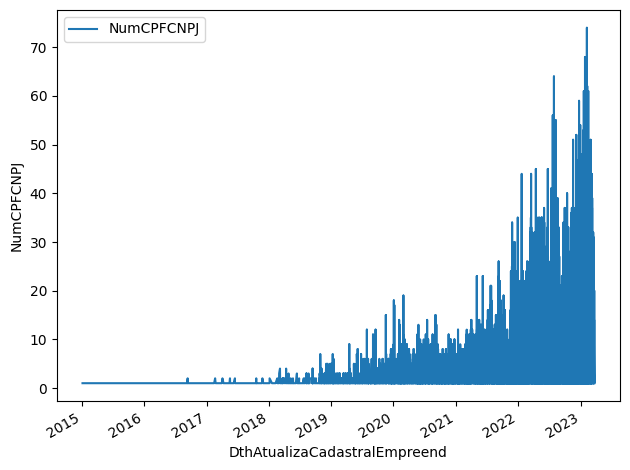

In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# VISUALIZAÇÃO GERAL
ts_clean.plot()
plt.xlabel('DthAtualizaCadastralEmpreend')
plt.ylabel('NumCPFCNPJ')
plt.tight_layout()

##### tendencia

In [330]:
# decomposição sazonal
import statsmodels.api
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(ts_clean['NumCPFCNPJ'], period = 12)

tendencia = resultado.trend
sazonalidade = resultado.seasonal
residuo = resultado.resid

Text(0.5, 1.0, 'Tendência')

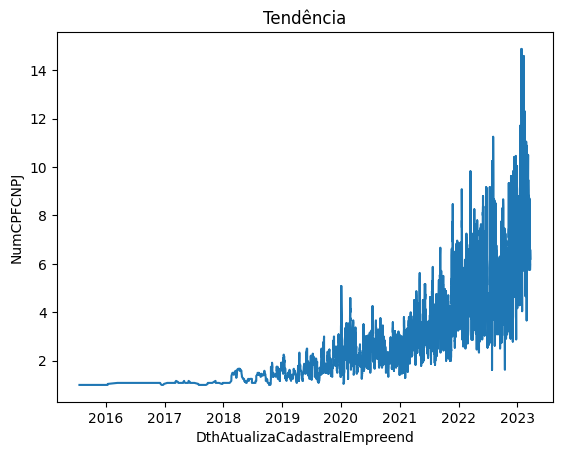

In [323]:
plt.plot(tendencia)
plt.xlabel('DthAtualizaCadastralEmpreend')
plt.ylabel('NumCPFCNPJ')
plt.title('Tendência')

# Aumento a longo prazo nos dados

##### sazonalidade

Text(0.5, 1.0, 'sazonalidade')

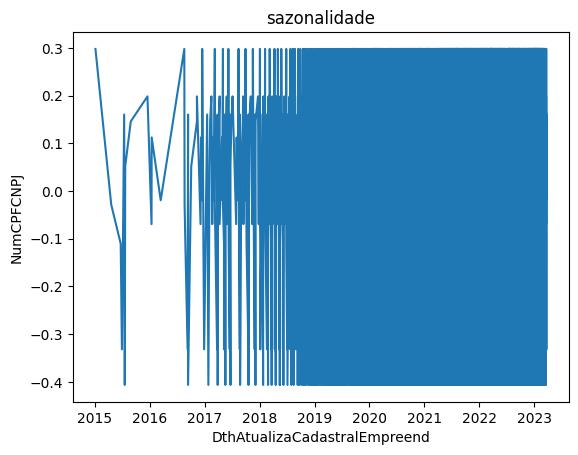

In [337]:

plt.plot(sazonalidade)
plt.xlabel('DthAtualizaCadastralEmpreend')
plt.ylabel('NumCPFCNPJ')
plt.title('sazonalidade')

# A sazonalidade crescente ocorre com a frequência cada vez maior, isso indica um aumento na "demanda"

##### residuo

Text(0.5, 1.0, 'residuo')

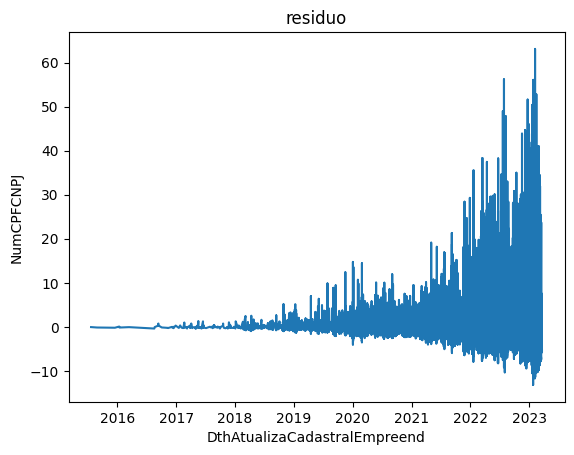

In [331]:
# RESIDUO

plt.plot(residuo)
plt.xlabel('DthAtualizaCadastralEmpreend')
plt.ylabel('NumCPFCNPJ')
plt.title('residuo')

# É a discrepância entre a tendência estimada da série e os valores reais da série.
# Se o modelo de previsão estiver bem ajustado, o resíduo deve ser aleatório e não apresentar padrões visíveis, indicando que não há mais informações a serem extraídas da série. Se, no entanto, houver padrões visíveis no resíduo, isso indica que o modelo não está capturando completamente a variação na série temporal.


##### autocorrelação(ACF) 

ACF é uma medida da correlação entre uma série temporal e a sua versão defasada (atrasada) em relação ao tempo. Ou seja, ela mede a relação entre os valores da série e os seus valores anteriores em diferentes defasagens. Um ACF com um decaimento rápido sugere que há pouca ou nenhuma correlação entre as observações defasadas da série temporal.

ACF mostra a correlação geral entre a série temporal e suas defasagens, permitindo a identificação de sazonalidades

    - Ajuda a entender se há uma relação entre os valores passados e presentes
    - Autocorrenação de pearson
        - acf > 0 = correlação positiva
        - acf < 0 = correlação negativa
        - acf = 0 = nenhuma correlação

    - ACF pode ser usado para remover sazonalidade
    - Ruido branco são series que não apresentam correlação 

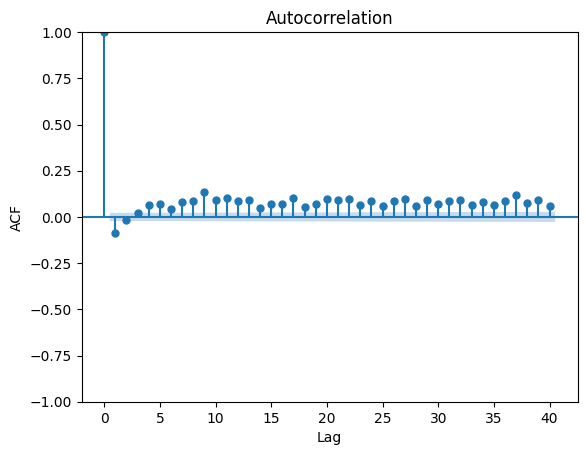

In [333]:
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(ts['NumCPFCNPJ'], lags=40)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# Quando tem uma queda mais rápida (0 p/ 1) dizemos que esse é o ACF = 1
# ACF é uma medida de correlação entre a série temporal e uma versão atrasada dela mesma.
# No caso do gráfico gerado pelo código, a autocorrelação é próxima de 0 em quase todos os lags, com exceção de um pico próximo de 0.2 em torno do lag 10. Isso pode indicar que há uma correlação fraca entre os valores da série a cada 10 períodos de tempo, mas em geral não há correlação significativa.



##### autocorrelação parcial(PACF)


Define **p** do nosso podemo

Mede a correlação entre a série temporal e uma versão atrasada dela mesma, mas controlando a influência de outras defasagens intermediárias. Ou seja, a PACF remove a influência de defasagens intermediárias para que possamos ver a relação entre uma defasagem específica e a série temporal.

 PACF controla a influência de defasagens intermediárias e mostra a correlação específica entre uma defasagem
 
    -  Mede a correlação entre dois pontos em uma série temporal, levando em conta os efeitos das outras correlações  
        - regressão na qual predizemos y por x¹ e x²
        - regressão na qual predizemos x³ em função de x² e x³
        - correlacionamos as partes de y e x³ que são preditas por x¹ e x²

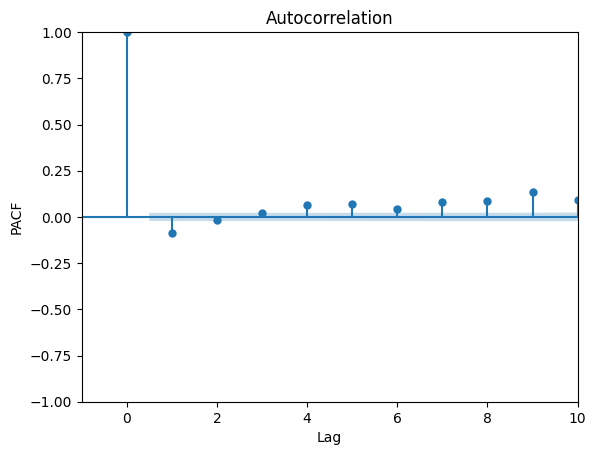

In [334]:
plot_acf(ts['NumCPFCNPJ'], lags=80, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.xlim([-1, 10])
plt.show()

# A autocorrelação parcial mede a correlação entre os valores da série em diferentes defasagens, controlando para as correlações em defasagens menores.
# Isso pode indicar uma correlação negativa fraca no início da série e uma correlação positiva moderada no primeiro intervalo de tempo.


##### Estacionariedade


##### Teste ADF e teste KPSS
Uma série temporal estacionária é aquela em que as propriedades estatísticas, como média e variância, são constantes ao longo do tempo. Em outras palavras, a distribuição dos dados não muda ao longo do tempo e não há tendências ou padrões sazonais. 


In [713]:
#ADF

from statsmodels.tsa.stattools import adfuller

resultado_ts = adfuller(ts_clean, autolag='AIC')
print('Estatística ADF: {:0.2f}'.format(resultado_ts[0]))
print('Número de atrasos: {}'.format(resultado_ts[2]))

# p<5% é um padrão estacionário, crescente controlado
print('Valor p: {:0.3f}'.format(resultado_ts[1]))
for key, value in resultado_ts[4].items():
    print('Valores críticos:')
    print("{}, {:0.2f}".format(key,value))

Estatística ADF: -3.24
Número de atrasos: 23
Valor p: 0.018
Valores críticos:
1%, -3.44
Valores críticos:
5%, -2.86
Valores críticos:
10%, -2.57


In [716]:
# KPSS

from statsmodels.tsa.stattools import kpss

estatistica_ts, valor_p_ts, n_atrasos_ts, valores_criticos_ts = kpss(ts_clean)


print('KPSS Statistic: {:0.2f}'.format(estatistica_ts))

# p<5% é um padrão estacionário, crescente controlado
print('Valor p: {:0.2f}'.format(valor_p_ts))
print('Número atrasos: {}'.format(n_atrasos_ts))
print('Valores críticos:')
for key, value in valores_criticos_ts.items():
    print("{} : {:0.2f}".format(key,value))

KPSS Statistic: 8.22
Valor p: 0.01
Número atrasos: 2
Valores críticos:
10% : 0.35
5% : 0.46
2.5% : 0.57
1% : 0.74


### Modelo Auto Regressivo (AR)

Prevê o valor baseado nos períodos anteriores até p, sendo um AR(p)


Essa relação (ACF e PACF) é utilizada em modelos AR (Auto Regressivo), que são modelos que usam valores passados para prever valores futuros da série temporal. O termo AR(1) refere-se a um modelo Auto Regressivo com uma defasagem (lag) - ou seja, o valor atual da série temporal é uma função do valor anterior mais um termo de erro.

O termo "lag" é comumente usado em séries temporais para se referir a um deslocamento de tempo. Por exemplo, se estamos analisando uma série temporal mensal, um "lag" de 1 corresponde a um deslocamento de um mês. No contexto do modelo AR, os "lags" se referem aos termos autorregressivos passados que são incluídos no modelo. O modelo AR(p) inclui "lags" de 1 a p, ou seja, os p termos autorregressivos passados mais relevantes para prever o valor atual da série.





- A variável é predita usando uma combinação linear das variáveis para prever
- Sõ latamente flexiveis em manipular series temporais
- A variância do termo erro mudará apenas a escala, não os padrões


Mudar os parâmetros Φ resulta em diferentes padrões

        - Φ = 0 (ruido branco)

        - Φ = 1, c=0 (caminhar aleatorio)

        - Φ = 0, c!=0 (caminhar aleatorio com deslize)

        - Φ < 0  (yt oscila ao redor da média) 

Restringimos o modelo AR para dados estacionários  com as restrições

        - AR(1) -1 > Φ  >1

        - AR(2) -1 < Φ¹ < 1 // Φ¹ + Φ² < 1 // Φ² - Φ¹ < 1


In [545]:
ar = ts_clean.copy()
pd.DataFrame(ar)

# criando variáveis de treino e teste
t_treino = ar[ar.index < '2020-06-01'].index.values
t_teste = ar[ar.index >= '2020-06-01'].index.values
X_treino = ar[ar.index < '2020-06-01'].values
X_teste = ar[ar.index >= '2020-06-01'].values



AutoReg Model Results

A análise a seguir pode ajudar a entender como as defasagens afetam a variável dependente e como elas podem ser usadas para prever os valores futuros. Alguns pontos importantes a serem observados incluem:

- Os coeficientes das defasagens, que mostram o quanto o valor da variável dependente é afetado por seus próprios valores passados. Coeficientes com valores altos e significativos indicam que as defasagens são importantes para explicar a variação na variável dependente.
- Os valores-p dos coeficientes, que indicam se eles são estatisticamente significativos ou não. Valores-p baixos (geralmente < 0,05) indicam que é improvável que os coeficientes sejam iguais a zero ao acaso, o que sugere que eles são importantes para o modelo.
- O valor do AIC e do BIC, que são critérios de seleção de modelo que penalizam modelos mais complexos. Modelos com valores menores de AIC e BIC são considerados melhores ajustados e mais adequados para previsão. No entanto, é importante lembrar que esses critérios são apenas uma medida aproximada da qualidade do modelo e não devem ser usados isoladamente para tomar decisões de modelagem.

In [546]:
from statsmodels.tsa.ar_model import AutoReg

# Cria modelo com índice 1
modelo = AutoReg(x_treino, 1)
# ajusta o modelo
resultado = modelo.fit()
print(resultado.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  170
Model:                     AutoReg(1)   Log Likelihood                -113.964
Method:               Conditional MLE   S.D. of innovations              0.475
Date:                Wed, 29 Mar 2023   AIC                            233.927
Time:                        11:16:43   BIC                            243.317
Sample:                             1   HQIC                           237.738
                                  170                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0193      0.096     10.640      0.000       0.832       1.207
y.L1           0.1211      0.076      1.586      0.113      -0.029       0.271
                                    Roots           

- O coeficiente constante é 1.0193, o que indica que o modelo espera que a variável dependente tenha um valor médio de 1.0193.
- O coeficiente y.L1 é 0.1211. Este é o coeficiente do atraso (lag) 1 da variável dependente. Isso significa que o modelo assume que o valor da - variável dependente em um determinado momento é uma função linear do valor da variável dependente no momento anterior, ponderado pelo coeficiente de 0,1211.
- O valor do logaritmo da verossimilhança é -113,964, o que indica a qualidade do modelo ajustado.
- O valor p para o coeficiente y.L1 é 0,113, o que indica que o coeficiente não é estatisticamente significativo a um nível de significância de 0,05. Isso significa que não há evidência estatística para suportar a ideia de que a variável dependente depende de seu próprio valor atrasado em um período anterior.

Os índices parecem adequados para o modelo AR. O valor do Log Likelihood negativo indica que o modelo está ajustando bem aos dados. Além disso, o valor do AIC é menor que o valor do BIC, o que é uma indicação de que o modelo é melhor para ajustar os dados. O valor do coeficiente da constante é significativo, indicando que há uma tendência na série temporal. No entanto, o coeficiente do primeiro atraso (y.L1) não é significativo a um nível de 5%, o que pode indicar que o modelo pode ser melhorado adicionando mais atrasos.

In [547]:
# Coeficientes calculados pelo modelo de regressão autorregressiva 
# Esses coeficientes são usados para multiplicar os valores passados no período anterior para estimar o valor atual.

print('coefficients: %s' % resultado.params)

# O modelo estima o valor atual de acordo com os valores anteriores, usando esses coeficientes como pesos. Portanto, os coeficientes podem ser úteis para entender como o modelo está estimando o valor atual e para fazer previsões futuras com base nesses coeficientes.

coefficients: [1.01927195 0.12113796]


In [548]:
# O AIC (Akaike Information Criterion) é um critério de seleção de modelos utilizado para comparar a qualidade de diferentes modelos estatísticos.
# Quanto menor o valor do AIC, melhor é o modelo

AIC = resultado.aic
print('AIC: {:.2f}'.format(AIC))

# O valor de AIC de 233.93 indica que o modelo apresenta uma boa qualidade de ajuste, sendo um indicativo de que o modelo é capaz de explicar bem a variabilidade dos dados.


AIC: 233.93


#### Predições

In [722]:
# É utilizada para fazer previsões com o modelo treinado. No caso específico, a função predict() é utilizada para fazer previsões do modelo resultado a partir do índice start até o índice end.

X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)

# O parâmetro dynamic=False significa que a previsão deve ser feita usando valores previstos anteriormente (usando a previsão para cada período anterior como entrada para prever o período seguinte)

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.,
        18993., 19358.]),
 [Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023')])

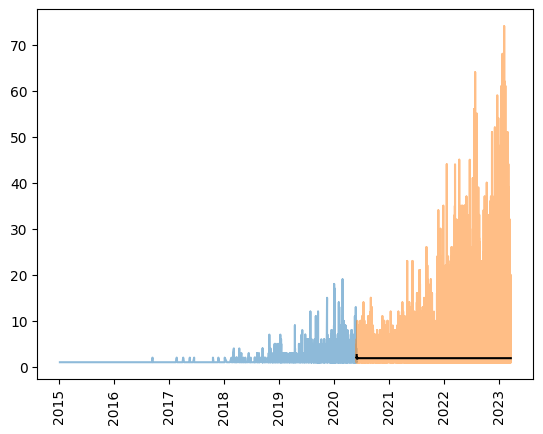

In [723]:
# Faz uma previsão
plt.plot(t_treino, X_treino, alpha = 0.5)
plt.plot(t_teste, X_teste, alpha=0.5)
plt.plot(t_teste, X_pred, color='black')
plt.xticks(rotation=90)
#plt.show()

#### calculando Erros

In [721]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(x_teste, x_pred)
RMSE = np.sqrt(MSE)
print('RMSE: {:.2f}'.format(RMSE))
print('MSE: {:.2f}'.format(MSE))

# RMSE (Root Mean Squared Error) indica a diferença média entre os valores previstos e os valores observados
    # para nossa análise com valores que vão até 70 é alto

# MSE (Mean Squared Error) indica a média dos erros quadrados entre os valores previstos e os valores observados 

RMSE: 7.19
MSE: 51.70


#### determinando qual o melhor modelo

In [552]:
# Avaliar a performance do modelo e comparar diferentes modelos entre si.

for i in range (1,20):
    modelo = AutoReg(x_treino, i)
    resultado = modelo.fit()
    AIC = resultado.aic
    x_pred = resultado.predict(start=len(x_treino), end=len(x_treino)+len(x_teste)-1, dynamic=False)
    MSE = mean_squared_error(x_teste, x_pred)
    RMSE = np.sqrt(MSE)
    print("i = {} AIC = {:.2f} RMSE = {:.2f} MSE = {:.2f}".format(i, AIC, RMSE, MSE))

# *PRINCIPAL* O AIC é um indicador de qualidade de um modelo, que considera tanto o ajuste aos dados quanto a complexidade do modelo. Quanto menor o valor do AIC, melhor é o modelo.
    # o melhor modelo é o 17
# O RMSE é a raiz quadrada do MSE e indica a diferença entre os valores reais e previstos. Quanto menor o valor, melhor é o modelo.
# O MSE indica a média dos erros ao quadrado entre o valor real e o previsto. Quanto menor o valor, melhor é o modelo.

i = 1 AIC = 233.93 RMSE = 7.20 MSE = 51.84
i = 2 AIC = 235.39 RMSE = 7.20 MSE = 51.83
i = 3 AIC = 236.57 RMSE = 7.20 MSE = 51.83
i = 4 AIC = 238.12 RMSE = 7.20 MSE = 51.82
i = 5 AIC = 239.61 RMSE = 7.20 MSE = 51.81
i = 6 AIC = 240.44 RMSE = 7.20 MSE = 51.81
i = 7 AIC = 229.78 RMSE = 7.20 MSE = 51.78
i = 8 AIC = 231.05 RMSE = 7.20 MSE = 51.78
i = 9 AIC = 231.42 RMSE = 7.20 MSE = 51.77
i = 10 AIC = 230.87 RMSE = 7.19 MSE = 51.75
i = 11 AIC = 232.24 RMSE = 7.19 MSE = 51.75
i = 12 AIC = 230.71 RMSE = 7.19 MSE = 51.72
i = 13 AIC = 232.29 RMSE = 7.19 MSE = 51.72
i = 14 AIC = 233.45 RMSE = 7.19 MSE = 51.72
i = 15 AIC = 233.94 RMSE = 7.19 MSE = 51.73
i = 16 AIC = 229.50 RMSE = 7.19 MSE = 51.69
i = 17 AIC = 225.00 RMSE = 7.19 MSE = 51.73
i = 18 AIC = 226.60 RMSE = 7.19 MSE = 51.71
i = 19 AIC = 228.31 RMSE = 7.19 MSE = 51.70


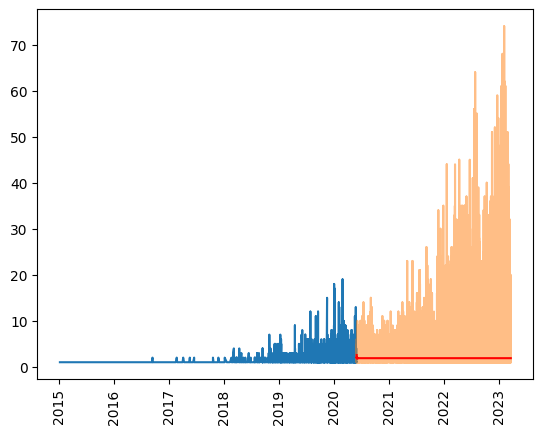

In [555]:
modelo = AutoReg(X_treino, 14)
resultado = modelo.fit()
X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)

plt.plot(t_treino, X_treino)
plt.plot(t_teste, X_teste, alpha=0.5)
plt.plot(t_teste, X_pred, color='red')   
plt.xticks(rotation=90)
plt.show()

### Média móvel

In [703]:
mm = ts_clean.copy()
pd.DataFrame(mm)

t_treino_mm = mm[mm.index < '2023-01-01'].index
t_teste_mm = mm[mm.index >= '2023-01-01'].index
X_treino_mm = mm[mm.index < '2023-01-01']
X_teste_mm = mm[mm.index >= '2023-01-01']


# calcula o número de previsões que serão feitas para os dados de teste.
forecast = len(X_teste_mm)

# cria um dataframe com os dados de teste e com a coluna de previsões zerada.
y_hat_avg = X_teste_mm.copy()

# cria uma coluna de previsões zerada.
y_hat_avg['predicao'] = 0
len(y_hat_avg['predicao'])

44

In [704]:
# faz um loop para preencher a coluna de previsões com a média móvel dos dados de treino.

for i in range(forecast):
    y_hat_avg['predicao'].iloc[i] = X_treino_mm['NumCPFCNPJ'].rolling(i).mean().iloc[-1]

In [705]:
# remove os valores nulos do dataframe.

#y_hat_avg = y_hat_avg.dropna()

len(y_hat_avg['predicao'])


44

Graficando

In [706]:
t_treino_mm = t_treino_mm.values
X_treino_mm = X_treino_mm.values
X_teste_mm = X_teste_mm.values
t_teste_mm = t_teste_mm.values
X_pred_mm = y_hat_avg.values

In [692]:
#plt.plot(t_teste, X_pred)

#tst = pd.DataFrame(t_teste, X_pred)
len(X_pred_mm)

44

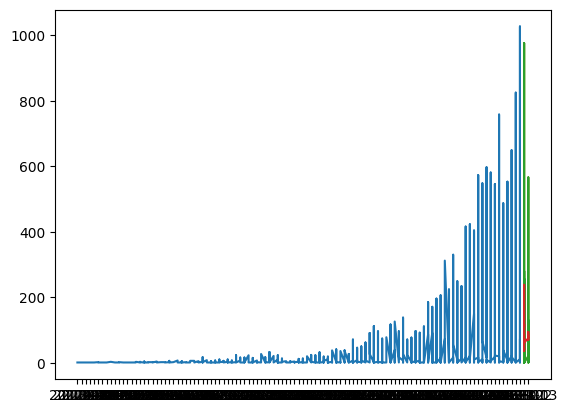

In [711]:
plt.plot(t_treino_mm,X_treino_mm)
plt.plot(t_teste_mm,X_teste_mm, alpha=0.5)
plt.plot(t_teste_mm,X_pred_mm)

In [712]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(X_teste_mm,y_hat_avg['predicao'])

RMSE = np.sqrt(MSE)

print("RMSE = {:0.2f}".format(RMSE))

ValueError: Input contains NaN.